In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

import sys

from importlib import reload

import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)s | %(name)s | %(levelname)s : %(message)s',
    level=logging.INFO,
    stream=sys.stdout
)

logger = logging.getLogger('hysped')
logger.setLevel(logging.DEBUG)

import contextily as ctx
import geocube
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import re
import seaborn as sns
import shapely
import tensorflow as tf
import visualkeras
import zipfile

import wandb
wandb.login()

from functools import partial
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from IPython.display import JSON, HTML
from keras.utils.np_utils import to_categorical
from matplotlib.colors import to_rgba
from shapely.geometry import box, mapping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tqdm.notebook import trange, tqdm
from wandb.keras import WandbMetricsLogger, WandbEvalCallback, WandbModelCheckpoint


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # configure utilization of GPUs
    try:
        for gpu in gpus:
            # memory growth setting
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=256)]
            )
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        module_logger.error(e)


# Make numpy values easier to read.
np.set_printoptions(precision=6, suppress=True)

%matplotlib inline

wandb: Currently logged in as: stevo (hysped). Use `wandb login --relogin` to force relogin


In [2]:
def mkdir(path):
    if not os.path.isdir(path):
        if not os.path.exists(path):
            os.mkdir(path)
            
def predict_model(m, X, Y, label_encoder):
    Y_pred = m.predict(X)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_pred = label_encoder.inverse_transform(Y_pred)
    Y_pred = pd.DataFrame(Y_pred, columns=['Y_pred'])
    return Y_pred

def plot_cm(ax, cm, labels, title='Confusion Matrix'):
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        ax=ax,
        cmap='Blues',
        # square=True,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=1,
        # annot_kws={'size': 12}
    )

    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

## Configuration

In [3]:
cfg = dict(
    data_dir = os.path.join('..', 'data', 'Sverepec_spolu_preprocessed_top4'),
    models_dir = os.path.join('..', 'models'),
    class_column = 'DRUH_DR',
    model_name = 'conv1D_top4',
    num_conv1D_layers = 3,
)
cfg['project_name'] = 'hysped-%s' % cfg['model_name']

mkdir(cfg['models_dir'])
display(JSON(cfg, expanded=True))

<IPython.core.display.JSON object>

## Load data

In [4]:
X_train = pd.read_parquet(os.path.join(cfg['data_dir'], 'X_train.parquet'))
Y_train = pd.read_parquet(os.path.join(cfg['data_dir'], 'Y_train.parquet'))
X_val = pd.read_parquet(os.path.join(cfg['data_dir'], 'X_val.parquet'))
Y_val = pd.read_parquet(os.path.join(cfg['data_dir'], 'Y_val.parquet'))

label_encoder = LabelEncoder()
encoder_filename = os.path.join(cfg['data_dir'], 'encoder-%s.npy' % cfg['class_column'])
label_encoder.classes_ = np.load(encoder_filename, allow_pickle=True)

num_classes = len(label_encoder.classes_)

X_train = X_train.values
Y_train = to_categorical(
    label_encoder.transform(Y_train[cfg['class_column']]),
    num_classes=num_classes
)

X_val = X_val.values
Y_val = to_categorical(
    label_encoder.transform(Y_val[cfg['class_column']]),
    num_classes=num_classes
)

## Model architecture

In [51]:
def make_model(
    input_shape: tuple,
    filters: [int],
    kernel_sizes: [int],
    num_classes: int,
    padding: str,
    **kwargs
):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Input(
            shape=input_shape
        )
    )
    model.add(
        tf.keras.layers.BatchNormalization()
    )
    
    for f,k in zip(filters, kernel_sizes):
        model.add(
            tf.keras.layers.Conv1D(
                filters=f,
                kernel_size=k,
                activation=tf.nn.relu,
                padding=padding
            )
        )
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
        
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(num_classes * 2))
    model.add(tf.keras.layers.Dense(num_classes))
    model.add(tf.keras.layers.Softmax())
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

## Train model

In [30]:
config = dict(
    input_shape=(X_train.shape[1], 1),   
    filters=[512,256,128,64],
    kernel_sizes=[9,7,5,3],
    num_classes=Y_train.shape[1],
    padding='causal'
)

run = wandb.init(
    project=cfg['project_name'],
    config=config
)
logger.info('run.id: %s, run.name: %s' % (run.id, run.name))

model = make_model(**run.config)
model.summary()

model_dir = os.path.join(cfg['models_dir'], cfg['model_name'])
mkdir(model_dir)
logger.info('model_dir: %s' % model_dir)
model_file = os.path.join(model_dir, 'run_%s_model.h5' % (run.id))
logger.info('model_file: %s' % model_file)

wandbModelCheckpoint = WandbModelCheckpoint(
    model_file,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True
)

callbacks = [
    WandbMetricsLogger(),
    wandbModelCheckpoint,
]

history = model.fit(
    x=X_train,
    y=Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    shuffle=True,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

run.finish()
wandb.finish()

2023-04-07 13:32:32,626 | hysped | INFO : run.id: gtsmpet1, run.name: balmy-music-78
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 186, 1)           4         
 hNormalization)                                                 
                                                                 
 conv1d_12 (Conv1D)          (None, 186, 512)          5120      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 93, 512)          0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 93, 256)           917760    
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 46, 256)          0         
 1D)                               

epoch/categorical_accuracy,▁▃▄▄▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇█████▇██████████▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▂
epoch/val_categorical_accuracy,▁▁▁▁▂▃▅▄▇▆▇▇▇█▇▇▇██▇█▇█████▆██████████▇█
epoch/val_loss,▅▆█▇▆▅▃▃▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁
epoch/categorical_accuracy,0.84666
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.41076
epoch/val_categorical_accuracy,0.89089


## Confusion matrix

136/136 [==============================] - 1s 5ms/step


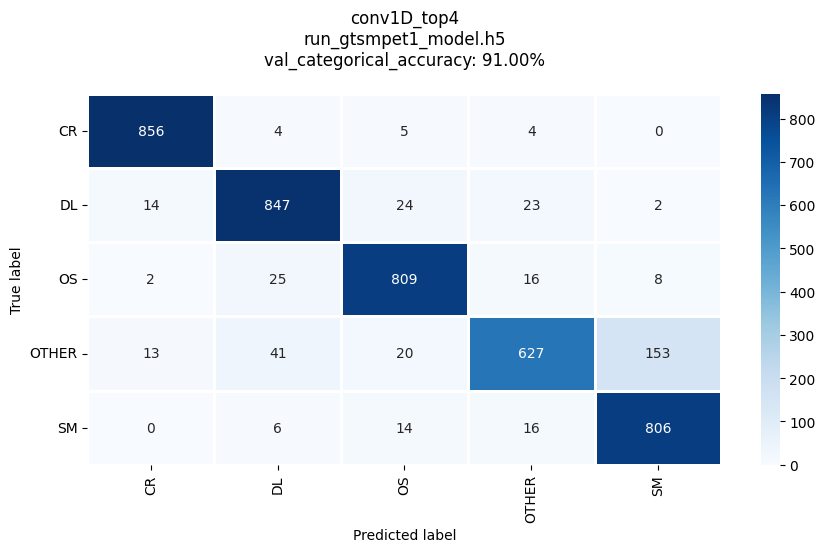

In [31]:
# load the best model
m = tf.keras.models.load_model(wandbModelCheckpoint.filepath)

Y_pred = predict_model(m, X_val, Y_val, label_encoder=label_encoder)
cm = confusion_matrix(label_encoder.inverse_transform(np.argmax(Y_val, axis=1)), Y_pred)

fig, ax = plt.subplots(figsize=(9,5))
plot_cm(ax, cm, labels=label_encoder.classes_)
plt.title('%s\n%s\n%s: %.2f%%\n' % (cfg['model_name'], os.path.basename(model_file), wandbModelCheckpoint.monitor, wandbModelCheckpoint.best * 100.0))
plt.show()

## Hyperparameter tuning

In [32]:
# Define the search space
sweep_configuration = {
    'method': 'random',
    'metric': {
        'goal': 'maximize',
        'name': 'val_categorical_accuracy'
    },
    'parameters': {
        'input_shape': {
            'values': [(X_train.shape[1], 1)]
        },
        'num_classes': {
            'values': [num_classes]
        },
        'kernel_sizes': {
            'values': [
                [kernel_size for conv1d_layer in range(cfg['num_conv1D_layers'])] for kernel_size in [3,5,7,9,11,13,15]
            ]
        },
        'filters': {
            'values': [
                [2**(conv1d_layer+i) for conv1d_layer in range(cfg['num_conv1D_layers'],0,-1)] for i in range(8)
            ]
        },
        'batch_size': {
            'values': [
                128
            ]
        },
        'padding': {
            'values': [
                'causal'
            ]
        }
    }
}

display(JSON(sweep_configuration, expanded=True))

<IPython.core.display.JSON object>

In [ ]:
def main():
    run = wandb.init(project=cfg['project_name'])
    model = make_model(**wandb.config)
    
    model_dir = os.path.join(cfg['models_dir'], cfg['model_name'])
    mkdir(model_dir)
    logger.info('model_dir: %s' % model_dir)
    model_file = os.path.join(model_dir, 'run_%s_model.h5' % (run.id))
    logger.info('model_file: %s' % model_file)
    
    wandbModelCheckpoint = WandbModelCheckpoint(
        model_file,
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True
    )

    callbacks = [
        WandbMetricsLogger(),
        wandbModelCheckpoint,
    ]

    history = model.fit(
        x=X_train,
        y=Y_train,
        validation_data=(X_val, Y_val),
        epochs=50,
        shuffle=True,
        batch_size=wandb.config.batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    wandb.log({
        wandbModelCheckpoint.monitor: wandbModelCheckpoint.best
    })
    run.finish()
    # wandb.log(pd.DataFrame(history.history)[-1:].reset_index(drop=True).to_dict(orient='records')[0])

# Start the sweep
sweep_id = wandb.sweep(
    sweep=sweep_configuration,
    project=cfg['project_name']
)
wandb.agent(sweep_id, function=main, count=50)
wandb.finish()

Create sweep with ID: z1gj71w2
Sweep URL: https://wandb.ai/hysped/hysped-conv1D_top4/sweeps/z1gj71w2


wandb: Agent Starting Run: ic3x6ked with config:
wandb: 	batch_size: 128
wandb: 	filters: [256, 128, 64]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:21:25,072 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:21:25,073 | hysped | INFO : model_file: ../models/conv1D_top4/run_ic3x6ked_model.h5
Epoch 1/50
80/80 [==============================] - 5s 32ms/step - loss: 1.3464 - categorical_accuracy: 0.3893 - val_loss: 3.5448 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.1972 - categorical_accuracy: 0.4921 - val_loss: 5.1735 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0207 - categorical_accuracy: 0.5811 - val_loss: 4.6646 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 0.9324 - categorical_accuracy: 0.6237 - val_loss: 6.0264 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 0.8778 - categorical_accuracy: 0.6538 - val_loss: 5.3316 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇██▇██▇████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▄▃▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▃▄▇▇▇▇▇▇▇▇▇██▇▇██▇█▇███▇██▇▇█▇▇████
epoch/val_loss,▅▇▆█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.76214
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.63778


wandb: Agent Starting Run: gjjjn2dm with config:
wandb: 	batch_size: 128
wandb: 	filters: [128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:22:50,406 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:22:50,407 | hysped | INFO : model_file: ../models/conv1D_top4/run_gjjjn2dm_model.h5
Epoch 1/50
80/80 [==============================] - 5s 27ms/step - loss: 1.3244 - categorical_accuracy: 0.4191 - val_loss: 1.6239 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0326 - categorical_accuracy: 0.5580 - val_loss: 1.6163 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 18ms/step - loss: 0.8845 - categorical_accuracy: 0.6261 - val_loss: 1.5995 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 0.8167 - categorical_accuracy: 0.6620 - val_loss: 1.7118 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 0.7919 - categorical_accuracy: 0.6757 - val_loss: 2.3706 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇███████▇███████▇████▇██
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▄▆▇▇▇▅▇▇██▇█▇█████▇▇█████▇▇███████▇
epoch/val_loss,██▇█▇▅▃▃▂▂▃▃▂▂▁▂▁▂▁▁▁▁▁▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▂
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.87781
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.34139


wandb: Agent Starting Run: ijedfaki with config:
wandb: 	batch_size: 128
wandb: 	filters: [256, 128, 64]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [5, 5, 5]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:24:14,158 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:24:14,159 | hysped | INFO : model_file: ../models/conv1D_top4/run_ijedfaki_model.h5
Epoch 1/50
80/80 [==============================] - 5s 32ms/step - loss: 1.3118 - categorical_accuracy: 0.4226 - val_loss: 2.4046 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0907 - categorical_accuracy: 0.5379 - val_loss: 3.5875 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 0.9282 - categorical_accuracy: 0.6222 - val_loss: 4.1987 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 18ms/step - loss: 0.8550 - categorical_accuracy: 0.6565 - val_loss: 5.7622 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 18ms/step - loss: 0.8040 - categorical_accuracy: 0.6827 - val_loss: 4.0170 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇▇▇████▇█▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▃▂▂▂▁▂▂▂▂▁▂▂▂▁▁▁▁▂▁▂
epoch/val_categorical_accuracy,▁▁▁▁▁▃▆▇▇▇▇██▇▇█▇████▇███████▇██████▇███
epoch/val_loss,▄▅▆█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.80049
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.53757


wandb: Agent Starting Run: ei88cage with config:
wandb: 	batch_size: 128
wandb: 	filters: [64, 32, 16]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:25:42,626 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:25:42,627 | hysped | INFO : model_file: ../models/conv1D_top4/run_ei88cage_model.h5
Epoch 1/50
80/80 [==============================] - 4s 22ms/step - loss: 1.4004 - categorical_accuracy: 0.3823 - val_loss: 1.7144 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 16ms/step - loss: 1.1869 - categorical_accuracy: 0.4997 - val_loss: 2.0533 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0582 - categorical_accuracy: 0.5568 - val_loss: 1.9048 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 0.9265 - categorical_accuracy: 0.6264 - val_loss: 1.8187 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 18ms/step - loss: 0.8908 - categorical_accuracy: 0.6293 - val_loss: 1.6712 - val_categorical_accuracy: 0.2962
Ep

epoch/categorical_accuracy,▁▃▄▅▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇█▆▆▇▇▇███████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▄▃▃▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▂▄▄▆▆▇▇▇▇▇█████▇▇▇█████████▇███████
epoch/val_loss,▇█▇▇▆▅▄▄▃▂▂▂▂▂▂▂▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.86653
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.36799


wandb: Agent Starting Run: uq7m7uva with config:
wandb: 	batch_size: 128
wandb: 	filters: [1024, 512, 256]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:27:06,417 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:27:06,418 | hysped | INFO : model_file: ../models/conv1D_top4/run_uq7m7uva_model.h5
Epoch 1/50
80/80 [==============================] - 8s 67ms/step - loss: 1.2138 - categorical_accuracy: 0.4780 - val_loss: 3.1839 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 4s 51ms/step - loss: 0.9735 - categorical_accuracy: 0.5984 - val_loss: 4.3630 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 4s 52ms/step - loss: 0.8485 - categorical_accuracy: 0.6663 - val_loss: 6.0674 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 4s 52ms/step - loss: 0.8450 - categorical_accuracy: 0.6709 - val_loss: 10.4430 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 4s 52ms/step - loss: 0.7448 - categorical_accuracy: 0.7172 - val_loss: 7.5590 - val_categorical_accuracy: 0.1970
E

epoch/categorical_accuracy,▁▃▅▅▆▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇██▇██▇██
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▃▃▃▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▂▁▁
epoch/val_categorical_accuracy,▁▁▁▁▁▂▅▇▇▇▇▇▇▇▇▇█▇█▇▇█▇▇█▇█▇██▇█████████
epoch/val_loss,▃▄▅█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.81878
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.49741


wandb: Agent Starting Run: pajxg0il with config:
wandb: 	batch_size: 128
wandb: 	filters: [32, 16, 8]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [7, 7, 7]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:30:49,329 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:30:49,330 | hysped | INFO : model_file: ../models/conv1D_top4/run_pajxg0il_model.h5
Epoch 1/50
80/80 [==============================] - 4s 21ms/step - loss: 1.4736 - categorical_accuracy: 0.3406 - val_loss: 1.5936 - val_categorical_accuracy: 0.2081
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.3038 - categorical_accuracy: 0.4409 - val_loss: 2.3351 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.1793 - categorical_accuracy: 0.5057 - val_loss: 3.0883 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0839 - categorical_accuracy: 0.5536 - val_loss: 3.2069 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0325 - categorical_accuracy: 0.5720 - val_loss: 2.8763 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇███████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▃▅▆▇▆▇▇▇▇▇▇▇▇▆▇█▇▇▇▇██▇▇██▇████████
epoch/val_loss,▄▆██▇▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.73297
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.70633


wandb: Agent Starting Run: s3yesut0 with config:
wandb: 	batch_size: 128
wandb: 	filters: [128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [9, 9, 9]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
